In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random
import cv2
import open3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
SEED = 1024

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
def convert_to_point_cloud(intrinsic, depth_image, depth_scale=1000, step=1):
    fx, fy = intrinsic.get_focal_length()
    cx, cy = intrinsic.get_principal_point()
    
    if depth_image.mode != "I":
        raise Exception("Depth image is not in intensity format")


    points = []
    for v in range(0, depth_image.height, step):
        for u in range(0, depth_image.width, step):
            z = depth_image.getpixel((u,v)) / depth_scale
            if z == 0: 
                continue
            x = (u - cx) * z / fx
            y = (v - cy) * z / fy
            points.append([x, y, z])
            
    xpcd = open3d.geometry.PointCloud()
    xpcd.points = open3d.utility.Vector3dVector(points)
    
    return xpcd

def read_intrinsic(filepath, width=640, height=480):
    m = np.loadtxt(filepath, dtype=np.float32)
    intrinsic = open3d.camera.PinholeCameraIntrinsic(width, height, m[0, 0], m[1, 1], m[0, 2], m[1, 2])
    return intrinsic

In [4]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super(ResBlock, self).__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()
            
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.norm2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        shortcut = self.shortcut(x)
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = x + shortcut
        return F.relu(x)
    
class Conv1x1(nn.Module):
    def __init__(self, in_channels, upsample=0):
        super(Conv1x1, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1, stride=1, padding=0)
        if upsample > 0:
            self.upsample = nn.Upsample(scale_factor=upsample, mode='nearest')
        else:
            self.upsample = None
    
    def forward(self, x):
        x = F.relu(self.conv(x))
        if self.upsample:
            return self.upsample(x)
        return x

In [6]:
class DepthNetworkV1(nn.Module):
    def __init__(self):
        super(DepthNetworkV1, self).__init__()
        
        self.layer0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer1 = ResBlock(64, 64, False)
        self.layer2 = ResBlock(64, 64, False)
        
        self.layer3 = ResBlock(64, 64, True)
        self.layer4 = ResBlock(64, 64, False)
        
        self.layer5 = ResBlock(64, 64, True)
        self.layer6 = ResBlock(64, 64, False)
        
        self.layer7 = ResBlock(64, 64, True)
        self.layer8 = ResBlock(64, 64, False)
        
        self.layer9 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.layer10 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer11 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.layer12 = nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0)
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample2 = nn.Upsample(scale_factor=4, mode='nearest')
        self.upsample3 = nn.Upsample(scale_factor=8, mode='nearest')
    
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        d1 = x
        x = self.layer3(x)
        x = self.layer4(x)
        d2 = self.upsample1(x)
        x = self.layer5(x)
        x = self.layer6(x)
        d3 = self.upsample2(x)
        x = self.layer7(x)
        x = self.layer8(x)
        d4 = self.upsample3(x)
        
        x = torch.cat((d1, d2, d3, d4), dim=1)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = F.relu(self.layer12(x))
        
        return x

class DepthNetwork(nn.Module):
    def __init__(self):
        super(DepthNetwork, self).__init__()
        
        self.layer0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer1 = ResBlock(64, 64, False)
        self.layer2 = ResBlock(64, 64, False)
        self.layer2d = Conv1x1(64)
        self.layer3 = ResBlock(64, 128, True)
        self.layer4 = ResBlock(128, 128, False)
        self.layer4d = Conv1x1(128, 2)
        self.layer5 = ResBlock(128, 256, True)
        self.layer6 = ResBlock(256, 256, False)
        self.layer6d = Conv1x1(256, 4)
    
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        d1 = self.layer2d(x)
        x = self.layer3(x)
        x = self.layer4(x)
        d2 = self.layer4d(x)
        x = self.layer5(x)
        x = self.layer6(x)
        d3 = self.layer6d(x)
        
        return d1 + d2 + d3

In [5]:
class DepthNetworkV2(nn.Module):
    def __init__(self):
        super(DepthNetworkV2, self).__init__()
        
        self.layer0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer1 = ResBlock(64, 64, False)
        self.layer2 = ResBlock(64, 64, False)
        
        self.layer3 = ResBlock(64, 64, True)
        self.layer4 = ResBlock(64, 64, False)
        
        self.layer5 = ResBlock(64, 128, True)
        self.layer6 = ResBlock(128, 128, False)
        
        self.layer7 = ResBlock(128, 256, True)
        self.layer8 = ResBlock(256, 256, False)
        
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.layer10 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.layer11 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer12 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.layer13 = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample2 = nn.Upsample(scale_factor=4, mode='nearest')
        self.upsample3 = nn.Upsample(scale_factor=8, mode='nearest')
    
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        d1 = x
        x = self.layer3(x)
        x = self.layer4(x)
        d2 = self.upsample1(x)
        x = self.layer5(x)
        x = self.layer6(x)
        d3 = self.upsample2(x)
        x = self.layer7(x)
        x = self.layer8(x)
        d4 = self.upsample3(x)
        
        x = torch.cat((d1, d2, d3, d4), dim=1)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        
        return x

In [41]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.norm4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.norm5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.norm6 = nn.BatchNorm2d(32)
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.norm7 = nn.BatchNorm2d(16)
        self.conv8 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=1, padding=0)

    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        x = F.relu(self.norm4(self.conv4(x)))
        x = F.relu(self.norm5(self.conv5(x)))
        x = F.relu(self.norm6(self.conv6(x)))
        x = F.relu(self.norm7(self.conv7(x)))
        x = F.relu(self.conv8(x))
        
        return x

In [5]:
class DepthNetworkV4(nn.Module):
    def __init__(self):
        super(DepthNetworkV4, self).__init__()
        
        self.layer0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.layer1 = nn.Sequential(
            ResBlock(64, 64, False),
            ResBlock(64, 64, False),
            ResBlock(64, 64, False)
        )
        
        self.layer2 = nn.Sequential(
            ResBlock(64, 128, True),
            ResBlock(128, 128, False),
            ResBlock(128, 128, False)
        )
        
        self.layer4 = nn.Sequential(
            ResBlock(128, 256, True),
            ResBlock(256, 256, False),
            ResBlock(256, 256, False),
            ResBlock(256, 256, False),
            ResBlock(256, 256, False),
            ResBlock(256, 256, False)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 1, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )
        
        
    
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        return x
    
class DepthNetworkV5(nn.Module):
    def __init__(self):
        super(DepthNetworkV5, self).__init__()
        
        self.layer0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.layer1 = nn.Sequential(
            ResBlock(64, 64, False),
            ResBlock(64, 64, False),
            ResBlock(64, 64, False)
        )
        
        self.layer2 = nn.Sequential(
            ResBlock(64, 128, True),
            ResBlock(128, 128, False),
            ResBlock(128, 128, False)
        )
        
        self.layer4 = nn.Sequential(
            ResBlock(128, 256, True),
            ResBlock(256, 256, False),
            ResBlock(256, 256, False),
            ResBlock(256, 256, False),
            ResBlock(256, 256, False),
            ResBlock(256, 256, False)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 1, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )
        
        
    
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

Using Device: cuda


In [ ]:
model = DepthNetworkV4().to(device)
model.load_state_dict(torch.load('models/resent_model_v4_larc_v2_best.pth'))
model.eval()

In [8]:
def predict(model, input_img, depth_scale, max_depth=None):
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_img)
        output = output.squeeze().clone().detach().cpu().numpy()
        
        if max_depth is not None:
            output = output * max_depth
        
        return np.asarray(output * depth_scale).astype(np.uint16)

In [9]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

In [31]:
sample_image_file = "D:/Projects/Research/LARCDataset/v1/larc-kitchen/seq-01/frame-000001.color.png"
intrinsic = read_intrinsic("D:/Projects/Research/LARCDataset/v1/larc-kitchen/camera-intrinsics.txt")
depth_scale = 4000

# sample_image_file = "D:/Projects/Research/3DMatch/dataset/7-scenes-redkitchen/seq-01/frame-000001.color.png"
# intrinsic = read_intrinsic("D:/Projects/Research/3DMatch/dataset/7-scenes-redkitchen/camera-intrinsics.txt")

# sample_image_file = "D:/Projects/Research/3DMatch/dataset/sun3d-harvard_c3-hv_c3_1/seq-01/frame-000001.color.png"
# intrinsic = read_intrinsic("D:/Projects/Research/3DMatch/dataset/sun3d-harvard_c3-hv_c3_1/camera-intrinsics.txt")

In [32]:
color_image = Image.open(sample_image_file)

input_img = transform(np.asarray(color_image))

In [33]:
depth_img = predict(model, input_img, depth_scale)

depth_img = Image.fromarray(depth_img).convert("I")

# Upsacle the depth image to the original size
depth_img = depth_img.resize((color_image.width, color_image.height), Image.NEAREST)

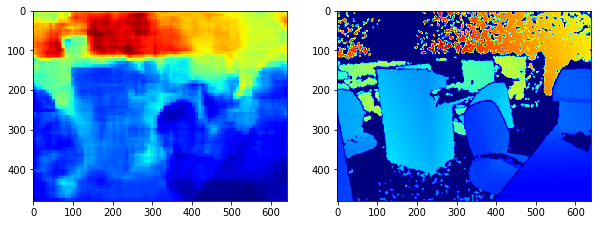

In [34]:
gt_depth_img = Image.open(sample_image_file.replace("color", "depth")).convert("I")


plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.asarray(depth_img), cmap="jet")

plt.subplot(1, 2, 2)
plt.imshow(np.asarray(gt_depth_img), cmap="jet")

In [40]:
gt_depth_data = np.asarray(gt_depth_img)

mask = np.where(gt_depth_data > 0, 1, 0)

In [41]:
# pcd = convert_to_point_cloud(intrinsic, depth_img, depth_scale)
pcd = convert_to_point_cloud(intrinsic, Image.fromarray(np.asarray(depth_img) * mask).convert("I"), depth_scale)

pcd = pcd.voxel_down_sample(voxel_size=0.1)
pcd.paint_uniform_color([0, 0.651, 0.929])

PointCloud with 5351 points.

In [42]:
open3d.visualization.draw_geometries([pcd])

In [37]:
# intrinsic = read_intrinsic("D:/Projects/Research/3DMatch/dataset/sun3d-harvard_c3-hv_c3_1/camera-intrinsics.txt")
# gt_depth_img = Image.open("D:/Projects/Research/3DMatch/dataset/sun3d-harvard_c3-hv_c3_1/seq-01/frame-000000.depth.png").convert("I")

gt_depth_img = Image.open(sample_image_file.replace("color", "depth"))

gt_pcd = convert_to_point_cloud(intrinsic, gt_depth_img, depth_scale)
gt_pcd = gt_pcd.voxel_down_sample(voxel_size=0.1)
gt_pcd.paint_uniform_color([1, 0.706, 0])


# open3d.visualization.draw_geometries([gt_pcd])

PointCloud with 3458 points.

In [43]:
open3d.visualization.draw_geometries([pcd, gt_pcd])

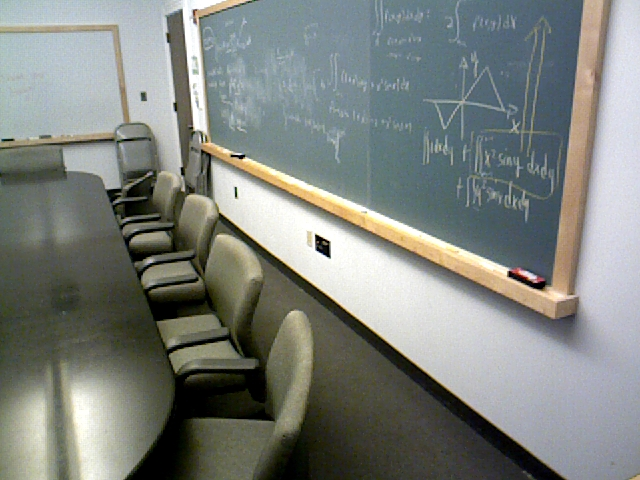

In [8]:
Image.open("D:/Projects/Research/3DMatch/dataset/sun3d-harvard_c3-hv_c3_1/seq-01/frame-000000.color.png")

In [3]:
intrinsic = read_intrinsic("iphone_depth_sample/camera_intrinsics.txt", width=320, height=240)

In [56]:
m = np.loadtxt("iphone_depth_sample/camera_intrinsics.txt", dtype=np.float32)
intrinsic = open3d.camera.PinholeCameraIntrinsic(320, 240, m[0, 0], m[1, 1], 160, 120)

In [51]:
depth_data = np.loadtxt("iphone_depth_sample/depth.txt")

# for i in range(320 * 240):
    

depth_data = depth_data.reshape(240, 320)

In [57]:
depth_img = Image.fromarray(np.array(depth_data * 1000, dtype="uint16")).convert("I")

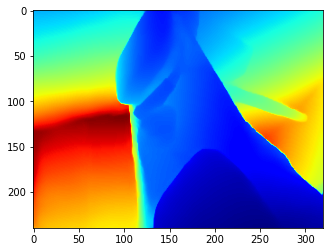

In [58]:
plt.imshow(depth_data, cmap="jet")

In [59]:
pcd = convert_to_point_cloud(intrinsic, depth_img, 1000)

In [60]:
open3d.visualization.draw_geometries([pcd])